In [1]:
!pip install numpy scipy torch torchaudio librosa soundfile
!pip install speechbrain

Taking Real-time Input

In [2]:
from IPython.display import display, Javascript, Audio
from google.colab import output

In [3]:
def toggle_recording():
    js_code = """
    let recording = false;
    let recorder;
    let chunks = [];

    function startRecording() {
        navigator.mediaDevices.getUserMedia({ audio: true })
            .then(function(stream) {
                recorder = new MediaRecorder(stream);
                recorder.ondataavailable = function(event) {
                    chunks.push(event.data);
                };

                recorder.onstop = function() {
                    let blob = new Blob(chunks, { type: 'audio/wav' });
                    let reader = new FileReader();
                    reader.onload = function() {
                        const base64Audio = reader.result.split(',')[1];
                        google.colab.kernel.invokeFunction('notebook.save_audio', [base64Audio], {});
                    };
                    reader.readAsDataURL(blob);
                };

                recorder.start();
                console.log("Recording started...");
                document.getElementById("toggle-button").innerText = "Stop Recording";
            })
            .catch(function(err) {
                console.log("Error: " + err);
            });
    }

    function stopRecording() {
        recorder.stop();
        console.log("Recording stopped...");
        document.getElementById("toggle-button").innerText = "Start Recording";
    }

    function toggleRecording() {
        if (!recording) {
            startRecording();
        } else {
            stopRecording();
        }
        recording = !recording;
    }

    const button = document.createElement("button");
    button.id = "toggle-button";
    button.innerText = "Start Recording";
    button.onclick = toggleRecording;

    document.body.appendChild(button);
    """
    display(Javascript(js_code))


In [4]:
def save_audio(base64_audio):
    import base64
    audio_data = base64.b64decode(base64_audio)

    with open('/content/recorded_audio.wav', 'wb') as f:
        f.write(audio_data)

    print("Audio saved successfully.")

In [5]:
output.register_callback('notebook.save_audio', save_audio)
toggle_recording()

<IPython.core.display.Javascript object>

Audio saved successfully.


In [6]:
import torchaudio

waveform, sample_rate = torchaudio.load("recorded_audio.wav")
duration = waveform.shape[1] / sample_rate
print(f"Recorded audio duration: {duration} seconds")

Recorded audio duration: 10.62 seconds


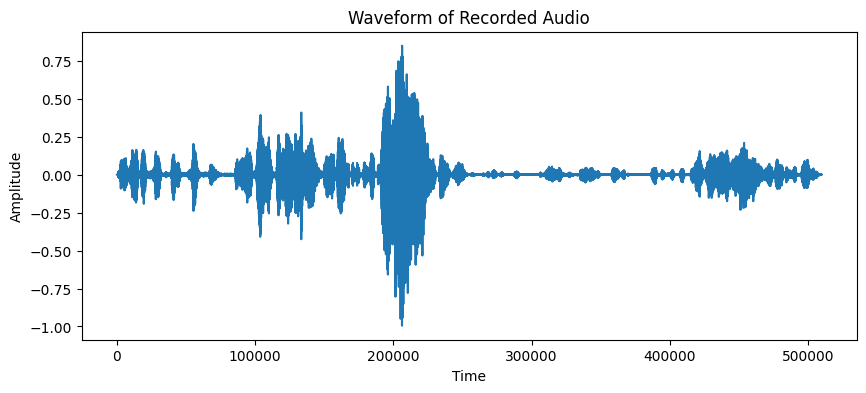

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(waveform[0].numpy())
plt.title("Waveform of Recorded Audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [8]:
import torchaudio.transforms as T

if sample_rate != 16000:
    resampler = T.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resampler(waveform)
    torchaudio.save("recorded_audio_resampled.wav", waveform, 16000)

In [9]:
from speechbrain.inference.separation import SepformerSeparation as separator
import torchaudio
import torch

In [14]:
model = separator.from_hparams(
    source="speechbrain/sepformer-wham16k-enhancement",
    savedir='pretrained_models/sepformer-wham16k-enhancement')
audio_sources = model.separate_file(path='/content/recorded_audio.wav')
if len(audio_sources[0].shape) == 1:
    enhanced_waveform = audio_sources[:,:,0].unsqueeze(0)  # Add channel dimension
else:
    enhanced_waveform = audio_sources[:,:,0]  # Already 2D
enhanced_waveform = enhanced_waveform / enhanced_waveform.abs().max()
torchaudio.save("converted_audio.wav", enhanced_waveform, 16000)

Resampling the audio from 48000 Hz to 16000 Hz


In [13]:
audio_sources[:, :, 0]

tensor([[-9.3813e-13, -4.7309e-12, -8.7826e-12,  ...,  1.2449e-04,
          1.1682e-04,  9.7256e-05]])

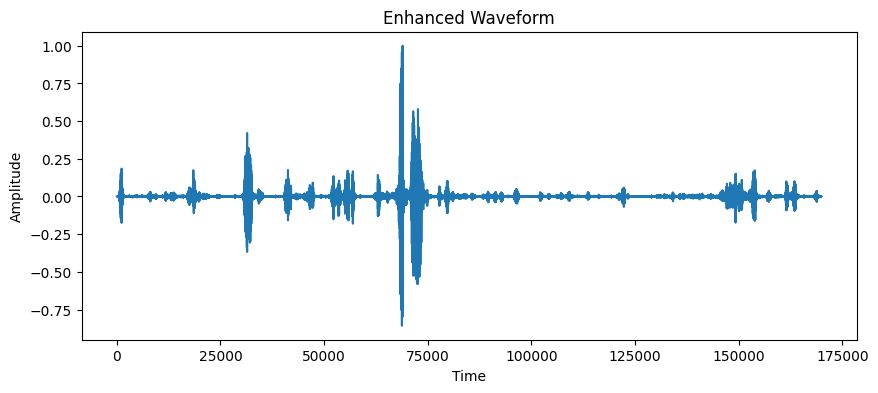

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(enhanced_waveform[0].numpy())
plt.title("Enhanced Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

<ipython-input-18-a4d4172a652d>:4: UserWarning: PySoundFile failed. Trying audioread instead.
  recorded_audio, sr_recorded = librosa.load('/content/recorded_audio.wav', sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


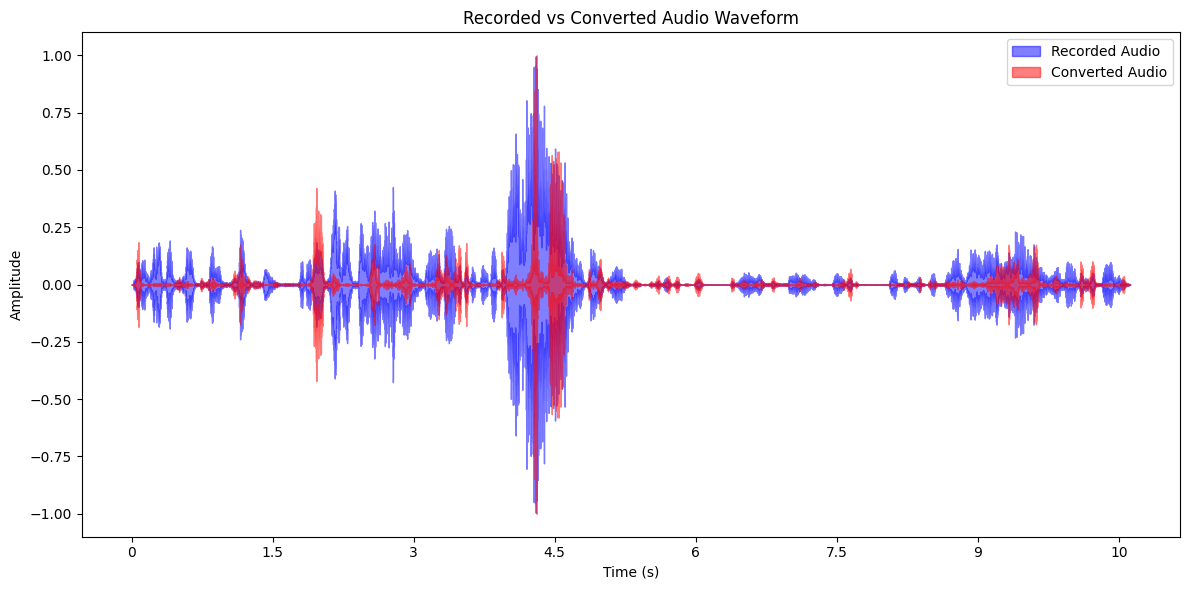

In [18]:
import librosa
import librosa.display

recorded_audio, sr_recorded = librosa.load('/content/recorded_audio.wav', sr=None)
converted_audio, sr_converted = librosa.load('converted_audio.wav', sr=None)

plt.figure(figsize=(12, 6))

librosa.display.waveshow(recorded_audio, sr=sr_recorded, color='b', alpha=0.5, label='Recorded Audio')

librosa.display.waveshow(converted_audio, sr=sr_converted, color='r', alpha=0.5, label='Converted Audio')

plt.title("Recorded vs Converted Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()